# What types of ML models are people using?

All results within the context of machine learning with sklearn.
- Supervised learning is much more common than unsupervised learning.
- Within supervised models, linear models are the most common, followed by ensemble methods.
- Within unsupervised models, decomposition is the most popular, followed by clustering.
-----------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import re

In [2]:
import load_data
notebooks, cells, owners, readmes, repos = load_data.load(lang='python')

In [3]:
def agg_lists(list_of_lists):
    overall = []
    for li in list_of_lists:
        for l in li:
            overall.append(l)
    return overall

nb_imports = cells.groupby('file')['imports'].aggregate(agg_lists).reset_index()
nb_code = cells.groupby('file')['code'].aggregate(agg_lists).reset_index()
nbs = nb_imports.merge(nb_code, on = 'file')

In [4]:
def get_uses(row):
    frameworks = ['tensorflow', 'sklearn', 
              'keras', 'theano', 'mxnet', 
              'caffe', 'pytorch', 'cntk']
    uses = {}
    for im in row.imports:
        if sum([im[0].startswith(f) for f in frameworks]) > 0:
            uses[im[0]] = set([])
            as_alias = im[1]
            for line in row.code:
                line = line.split('#')[0]
                if as_alias in line and 'import' not in line:
                    use = as_alias+as_alias.join(line.split(as_alias)[1:])
                    use = re.split('[()\[\]=\s]', use)[0]
                    if use == as_alias or use.startswith(as_alias+'.'):
                        use = use.replace(as_alias, im[0])
                        uses[im[0]].add(use)
    return uses

In [5]:
framework_uses = [get_uses(row) for _, row in nbs.iterrows()]
nbs['framework_uses'] = framework_uses

In [6]:
sk_uses = sum([sum([f.startswith('sklearn') 
                    for f in framework]) 
               for framework in nbs.framework_uses])
tf_uses = sum([sum([f.startswith('tensorflow') 
                    for f in framework]) 
               for framework in nbs.framework_uses])
keras_uses = sum([sum([f.startswith('keras') 
                    for f in framework]) 
               for framework in nbs.framework_uses])

all_uses = sk_uses + tf_uses + keras_uses

print("There are: \n{0} ({1}%) notebooks using SciKitLearn \n{4} ({5}%) notebooks using Keras \n{2} ({3}%) notebooks using Tensorflow".format(
    sk_uses, round(100*sk_uses/all_uses, 2), tf_uses, round(100*tf_uses/all_uses, 2), keras_uses, round(100*keras_uses/all_uses, 2)
))

There are: 
52320 (57.29%) notebooks using SciKitLearn 
29933 (32.78%) notebooks using Keras 
9071 (9.93%) notebooks using Tensorflow


SciKitLearn is the most popular machine learning framework for Jupyter notebooks, as we saw in exploring [frameworks](2_Frameworks.ipynb).

# Comparing supervised and unsupervised

## Focusing on SciKitLearn

SciKitLearn has good documentation of all available models, making it easy to distinguish what model a user is deploying. On the other hand, Keras and Tensorflow have *parts* of models, called layers, that users can use to build different types of models. Keras is primarily for neural networks, and neural networks are primarily supervised learning. However, there are instances of using keras for unsupervised learning, and its very difficult to parse that information from the code itself. Tensorflow is even more difficult because it can use lots of different APIs (for instance, tensorflow can actually use keras). For these reasons, and because the majority of machine learning uses are SciKitLearn, I have decided to focus on SciKitLearn models for this section.

References
- [sklearn supervised](https://scikit-learn.org/stable/supervised_learning.html)
- [sklearn unsupervised](https://scikit-learn.org/stable/unsupervised_learning.html)


In [7]:
model_to_type = {
    'sklearn.linear_model': 'S',
    'sklearn.discriminant_analysis': 'S',
    'sklearn.kernel_ridge': 'S',
    'sklearn.svm': 'S',
    'sklearn.SGDClassifier': 'S',
    'sklearn.neighbors': 'S',
    'sklearn.gaussian_process': 'S',
    'sklearn.cross_decomposition': 'S',
    'sklearn.naive_bayes': 'S',
    'sklearn.tree': 'S',
    'sklearn.ensemble': 'S',
    'sklearn.multiclass': 'S',
    'sklearn.feature_selection': 'S',
    'sklearn.semi_supervised': 'S',
    'sklearn.isotonic': 'S',
    'sklearn.calibration': 'S',
    'sklearn.neural_network': 'S',
    
    'sklearn.mixture': 'U',
    'sklearn.manifold': 'U',
    'sklearn.cluster': 'U',
    'sklearn.decomposition': 'U',
    'sklearn.covariance': 'U',
    #'sklearn.neural_network.BernoulliRBM': 'U'
}

In [8]:
all_supervised = []
all_unsupervised = []
for framework_uses in nbs.framework_uses:
    for use in framework_uses:
        if use.startswith('sklearn') or use.startswith('keras'):
            major = '.'.join(use.split('.')[:2])
            if major in model_to_type:
                t = model_to_type[major]
                if t == 'S':
                    if use.startswith('sklearn.neural_network.BernoulliRBM'):
                        all_unsupervised.append(major)
                    else:
                        all_supervised.append(major)
                else:
                    all_unsupervised.append(major)

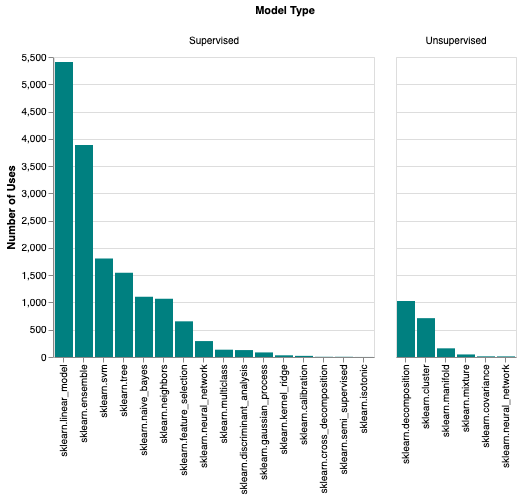

In [9]:
all_u_counts = pd.Series(all_unsupervised).value_counts().reset_index().rename(
    columns = {'index':'model', 0:'count'})
all_u_counts['type'] = 'Unsupervised'

all_s_counts = pd.Series(all_supervised).value_counts().reset_index().rename(
    columns = {'index':'model', 0:'count'})
all_s_counts['type'] = 'Supervised'

all_counts = all_u_counts.append(all_s_counts)

alt.Chart(all_counts).mark_bar(color = 'teal').encode(
    alt.X('model',
         sort = alt.EncodingSortField(field="count", op="sum",order="descending"),
         title = ''
    ),
    alt.Y('count', title = 'Number of Uses'),
    alt.Column('type', title = 'Model Type')
).resolve_scale(x = 'independent')

Supervised learning is much more common than unsupervised learning. I'll go over the contents of the most common model groups. For a full list, view the sklearn [documentation](https://scikit-learn.org/stable/supervised_learning.html). 

Within supervised learning, linear models are the most common. This includes regular least squares regression, ridge and lasso regression, elastic net, logistic regression, stochastic gradient descent.

Closely following linear models are ensemble methods, which includes bagging, random forests, adaboost, gradient tree boosting, voting classifiers, and voting regressors.

Within unsupervised learning, decomposition is the most popular. This includes PCA, singular value decomposition, dictionary learning, factor analysis, independent component analysis, non-negative matrix factorization, and latent dirichlet allocation.

Following decomposition is clustering, which incorperates k means, mean shift, hierarchical, dbscan, and more.

## Model type over time

## Do users import different packages depending on model type

<center> <a href = 4_Packages.ipynb>Python Package Use &lt;</a> | <a href = 6_Visualizations.ipynb>&gt; Visualizations</a> <center>